# Recommendation engines explained

We start by importing the relevant [Apache Spark](https://spark.apache.org/) modules and create a Spark session:

In [1]:
%matplotlib inline

from pyspark import SparkContext, SparkConf
from pyspark.sql import Row, SparkSession

spark = SparkSession.builder \
        .master("local") \
        .appName("recommender") \
        .config("spark.sql.crossJoin.enabled", "true") \
        .getOrCreate()

## The MovieLens dataset

The MovieLens dataset (already available with this notebook, originally [here](https://grouplens.org/datasets/movielens/)) is a popular dataset used in recommendation engines research.
In this workshop we will use the "small" variant, consisting of 20000263 ratings for 27278 movies by 138493 users.
This dataset consist of several CSV files, namely
 * A ratings data file (`ratings.csv`)
 * A tags data file (`tags.csv`)
 * A movies data file (`movies.csv`)
 * A links data file (`links.csv`)
 * A tag genome (`genome-scores.csv` and `genome-tags.csv`)
 
 For the scope of this workshop, we are mainly interest in the rating and movies data files, which have, respectively, the following structure:
 The ratings data:
 * `userId`, a unique numerical user id
 * `movieId`, a unique numerical movie id
 * `rating`, a numerical rating, as an integer from $0$ to $5$
 * `timestamp`, a numerical timestamp (not used in this exercise)
 The movies data:
 * `movieId`, as above
 * `title`, the movie title
 * `genres` a string label with the movie genre (as listed [here](http://files.grouplens.org/datasets/movielens/ml-20m-README.html)).
 
 ### Loading the data
 
 We start by using Apache Spark's built in functionality to load text files into the Spark cluster, `.textFile()` (documented [here](http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.SparkContext.textFile)), which will return an `RDD` of strings.
 Since `.textFile()` will read each row in the CSV file as an RDD entry, we further process it by then splitting each row into a list of CSV entries and keep only the relevant fields (i.e. `userId`, `movieId` and `rating` for the ratings, and `movieId` and `title` for the movies file).
 
 We then create a Spark [dataframe](https://spark.apache.org/docs/latest/sql-programming-guide.html) containing the entries.

In [2]:
def load_data(path, header, token_fun):
    """Loads the CSV file, strips the header and keeps only the specified fields"""
    rows = spark.sparkContext.textFile(path).filter(lambda x: x!=header).map(lambda x: x.split(",")).map(token_fun)
    # create a Spark dataframe from the RDDs
    return spark.createDataFrame(rows).cache()
    
    
# Load the movie data (movie id, title)
movies = load_data('ml-latest-small/movies.csv', 
                   'movieId,title,genres', 
                   lambda tokens: Row(item=int(tokens[0]),title=tokens[1]))

# Load the ratings (user id, movie id, rating)
ratings = load_data('ml-latest-small/ratings.csv', 
                    'userId,movieId,rating,timestamp', 
                    lambda tokens: Row(user=int(tokens[0]), item=int(tokens[1]), rating=float(tokens[2])))

In [3]:
print("Number of movies: {}".format(movies.count()))
print("Number of ratings: {}".format(ratings.count()))
movies.take(5)

Number of movies: 9742
Number of ratings: 100836


[Row(item=1, title='Toy Story (1995)'),
 Row(item=2, title='Jumanji (1995)'),
 Row(item=3, title='Grumpier Old Men (1995)'),
 Row(item=4, title='Waiting to Exhale (1995)'),
 Row(item=5, title='Father of the Bride Part II (1995)')]

We can now start by exploring the data.
Let's look at the ratings distribution:

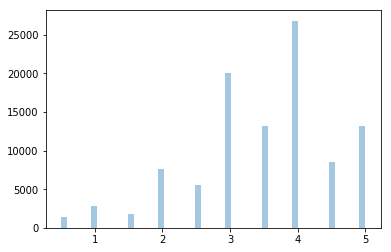

In [4]:
import seaborn as sns

r = ratings.select('rating').collect()
sns.distplot(r, kde=False)

We can see that most of the ratings are $4$ starts, followed by $3$ and $3.5$ stars. Users generally do not give very low ratings (e.g. $0.5$, $1$).

Let's try to see now the distribution of the number of ratings per user. That is, so user give many ratings on average?

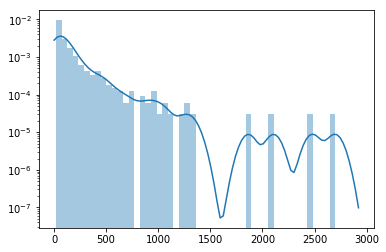

In [6]:
ratings_per_user = ratings.groupBy("user").count()
sns.distplot(ratings_per_user.select("count").collect(), hist_kws={'log':True}, kde_kws={'clip': (1.0, 3000.0)})

We can see that we have "super users", i.e. users that give more than 2000 ratings!
From this histogram its not easy to see how many they are, so lets find out.

In [7]:
from pyspark.sql.functions import col

ratings_per_user.filter(col('count') > 1500).groupBy('user').count().agg({"count":"sum"}).show()

+----------+
|sum(count)|
+----------+
|         4|
+----------+



So we only have $4$ "super" users. Let's now see how many users we have with less that 100 ratings:

In [8]:
ratings_per_user.filter(col('count') < 200).groupBy('user').count().agg({"count":"sum"}).show()

+----------+
|sum(count)|
+----------+
|       476|
+----------+



We can see that the vast majority of users gave less that $200$ ratings, which is a sensible number.

What about the movies? Do movies tend to have the same number of reviews or not? We can check by running:

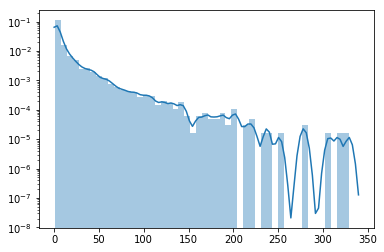

In [9]:
ratings_per_movie = ratings.groupBy("item").count()
sns.distplot(ratings_per_movie.select("count").collect(), hist_kws={'log':True}, kde_kws={'clip': (0, 3000.0)})

In [10]:
ratings_per_movie.filter(col('count') < 2).groupBy('item').count().agg({"count":"sum"}).show()

+----------+
|sum(count)|
+----------+
|      3446|
+----------+



# Alternating Least Squares (ALS)

Alternating Least Squares (ALS) is a standard algorithm for collaborative filtering. Its main rationale is that (conditioned on some item) users that agreed before are more likely to agree in the future.
In ALS, we aim at building a correlation matrix $M_{u,i}$ such that, given a rating $r$ given by a user $u$ to an item $i$ we have:

$$M_{u,i}=\begin{cases}
    r,& \text{if user}\ u\ \text{rated item}\ i\\
    0,& \text{if user}\ u\ \text{didn't rate item}\ i
\end{cases}$$

Provided we have a factor matrix $A$ for the users and a factor matrix $B$ for the movies, as the name implies, we use alternating least squares to first estimate $B\left(A\right)$ and then $A\left(B\right)$ until we reach convergence.

An important characteristics is that we want to penalise items without ratings, and as such we use

$$ w_{u,i}=\begin{cases}
    0,& \text{if}\ M_{u,i}=0\\
    1,& \text{otherwise}
\end{cases}$$

The cost functions to minimise are:
$$
\begin{align}
J\left(a_u\right) &= \left(m_u - a_u B\right)W_u\left(m_u-a_u B\right)^T + \lambda a_u a_u^T \\
J\left(b_i\right) &= \left(m_i - A b_i B\right)W_i\left(m_i-A b_i \right)^T + \lambda b_i b_i^T
\end{align}
$$

This is minimised using

$$
\begin{align}
a_u = \left(B W_u B^T + \lambda I\right)^{-1}B W_u m_u \\
b_u = \left(A W_i A^T + \lambda I\right)^{-1}A W_i m_i
\end{align}
$$

## Training the model

TODO: Explain the model

To train Spark's ALS model, we need to perform a few steps.
The first step is to define a metric to quantify "how good" our model is. This is done by chosing an error measure, which typically is the _mean squared error_ (MSE). The mean square error is formally defined by

$$
\text{MSE} = \frac{1}{N}\sum_{i=1}^{N}\epsilon_i^2, \qquad \epsilon_i = r_i - \hat{r}_i.
$$

That is, we first calculate the difference, $\epsilon_i$, between each pair of true rating ($r_i$) and it's corresponding _predicted_ rating ($\hat{r}_i$) and then calculated the average of the square of these errors. As example, consider a list of ratings `r1` and corresponding predictiong `r2`:

In [11]:
r1 = [4.5, 3.0, 1.0, 5.0, 4.0]
r2 = [4.56, 2.9, 1.1, 4.9, 3.2]

In [12]:
def mse(r, p):
    return sum([(pair[0] - pair[1])**2 for pair in zip(r, p)]) / len(r)

print("MSE = {}".format(mse(r1, r2)))

MSE = 0.13471999999999992


Since we've established our error measure, we can proceed to the next step.
We now need to split our data into a _training_, _test_ and _validation_ subsets.
We will use respectively the proportions 63%, 18% and 18% (you can try other ratios).

In [13]:
def split_sets(ratings, proportions):
    split = ratings.randomSplit(proportions, seed=42)
    return {'training': split[0], 'validation': split[1], 'test': split[2]}
    
sets = split_sets(ratings, [0.63212056, 0.1839397, 0.1839397])
print("Training dataset size = {}".format(sets['training'].count()))
print("Validation dataset size = {}".format(sets['validation'].count()))
print("Test dataset size = {}".format(sets['test'].count()))

Training dataset size = 63952
Validation dataset size = 18464
Test dataset size = 18420


The [parameters available](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=als#module-pyspark.ml.recommendation) for Spark's ALS class are:

ALS(rank=10, maxIter=10, regParam=0.1, numUserBlocks=10, numItemBlocks=10, implicitPrefs=False, alpha=1.0, userCol='user', itemCol='item', seed=None, ratingCol='rating', nonnegative=False, checkpointInterval=10, intermediateStorageLevel='MEMORY_AND_DISK', finalStorageLevel='MEMORY_AND_DISK', coldStartStrategy='nan')[source]¶

* `rank`, Rank of the feature matrices computed (number of features, default $10$)
* `maxIter`, Maximum number of iterations of ALS. (default: 10)
* `regParam`, Regularization parameter. (default: 0.1)
* `numUserBlocks`, Number of blocks used to parallelize the computation. A value of -1 will use an auto-configured number of blocks. (default: 10)
* `nonnegative`, A value of True will solve least-squares with nonnegativity constraints. (default: False)
* `seed`, Random seed for initial matrix factorization model. A value of None will use system time as the seed. (default: None)
* `implicitPrefs`, whether we are using implicit data or not (more on that later)
* `userCol`, name of the Dataframe column representing user ids
* `itemCol`, name of the Dataframe column representing movie ids
* `coldStrategy`, Strategy for dealing with unknown or new users/items at prediction time. This may be useful in cross-validation or production scenarios, for handling user/item ids the model has not seen in the training data. (either `nan` (default) or `drop`)

Let's try an ALS model with some arbitrary parameters, namely `rank=3`, `maxIter=5`, `regParam=0.1` and `coldStrategy='drop'`.

In [32]:
from pyspark.ml.recommendation import ALS

simple_als = ALS(maxIter=5, regParam=0.01, rank=3, coldStartStrategy='drop')

CPU times: user 20 ms, sys: 7.61 ms, total: 27.6 ms
Wall time: 2.82 s


After the `ALS` class instantiation, we specify the data to be used for training using the `.fit()` method:

In [33]:
%time simple_model = simple_als.fit(sets['training'])

CPU times: user 23.3 ms, sys: 8.55 ms, total: 31.8 ms
Wall time: 2.04 s


As we can see from the above, the training was quite quick ($2$ seconds in my case, yours may be different).

We can now calculate the MSE for this model, with the test datasets. To do so, we use the [Spark's](http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator) `RegressionEvaluator` class. In this class we can specify the error measure (`mse`, `rmse`, etc.) and the names of the labels (in our case the ratings) and the predictions columns.

In [31]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    metricName="mse",
    labelCol="rating",
    predictionCol="prediction")

mse = evaluator.evaluate(simple_model.transform(sets['test']))
print("MSE = {}".format(mse))

MSE = 0.9840127972425159


### Parameter estimation

The question now is, how do we know which parameters are the best? We first start by the definition of "best".
In this case, the "best" parameters will be the ones that would generate a model which when used with a dataset (other than the training), would produce the most accurate predictions. We've [seen above](#Training-the-model) that a way of determining this accuracy would be to use an error measure such the MSE.

To determine the parameters, we then use a "brute force" method: we train the model with a range of parameters, calculate the MSE, and choose the parameter combination which provides the smallest MSE.

We could of course do this manually, but Spark provives an utility method to automate the task for us.
We use the [`RegressionEvaluator` class](http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator) to calculate the MSE for each parameter combination and a [`TrainValidationSplit` class](http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.tuning.TrainValidationSplit) to perform the actual training.

(Below, we add the `coldStartStrategy` to the ALS class so that we automatically drop any `NaN` predictions.)

In [35]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

als = ALS(coldStartStrategy="drop")

param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [6, 8]) \
    .addGrid(als.maxIter,[10, 12]) \
    .build()

evaluator = RegressionEvaluator(
    metricName="mse",
    labelCol="rating",
    predictionCol="prediction")

tvs = TrainValidationSplit(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
)

%time model = tvs.fit(sets['training'])

CPU times: user 402 ms, sys: 111 ms, total: 513 ms
Wall time: 59.3 s


The `TrainValidationSplit` instance (`model`) stores the model with the smallest MSE in `model.bestModel`.
We can access the best parameters from our proposal in `model.bestModel`.

In [81]:
print("Best rank = {}".format(model.bestModel.rank))
print("Bext maxIter = {}".format(model.bestModel._java_obj.parent().getMaxIter()))

Best rank = 6
Bext maxIter = 12


If you want, you can search for the best parameter giving more options. Keep in mind, however, that the parameter grid search explores all _combinations_ of parameters, therefore the number trained models will grow exponentially, and of course, so will the time taken to perform the computations.

The `model` instance has a method (`.transform()`) which allows us to train the model. It will automatically assume the best model.
Lets perform the training and display the predictions. We will also join the prediction dataframe (which contains the movie ids) with the `movies` dataframe so we can see the actual titles of the movies.

In [40]:
prediction = model.transform(sets['test'])

prediction.alias('p').join(movies.alias('m'), col('p.item') == col('m.item')) \
    .select([col('p.user'), col('m.title'), col('p.prediction'), col('p.rating')]).show(100, truncate=False)

+----+--------------------------------+----------+------+
|user|title                           |prediction|rating|
+----+--------------------------------+----------+------+
|599 |"Hudsucker Proxy                |2.7932353 |2.5   |
|603 |"Hudsucker Proxy                |2.9024253 |4.0   |
|182 |"Hudsucker Proxy                |3.8016074 |4.5   |
|500 |"Hudsucker Proxy                |3.7163656 |1.0   |
|520 |"Hudsucker Proxy                |3.524216  |5.0   |
|411 |"Hudsucker Proxy                |2.932115  |4.0   |
|541 |"Hudsucker Proxy                |3.4211764 |3.0   |
|260 |"Hudsucker Proxy                |3.3195105 |4.5   |
|606 |Dirty Dancing (1987)            |3.4115505 |3.0   |
|599 |Dirty Dancing (1987)            |2.7029872 |2.5   |
|563 |Dirty Dancing (1987)            |3.7675972 |4.0   |
|381 |Dirty Dancing (1987)            |3.6416597 |3.5   |
|200 |Dirty Dancing (1987)            |4.060302  |4.0   |
|600 |Dirty Dancing (1987)            |3.045949  |3.5   |
|42  |Dirty Da

By glancing at this dataframe, we can see that many predictions are close to the true value, but some are way off.
First, lets visualise the error distribution.

(0, 5)

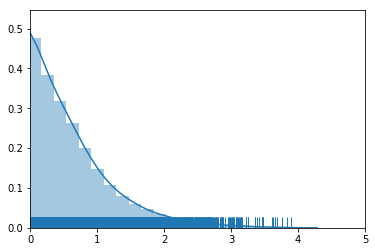

In [47]:
errors = prediction.withColumn('error', col('prediction')-col('rating')).select('error').collect()
ax = sns.distplot(errors, rug=True, hist=True)
ax.set_xlim(0, 5)

We can see that the majority of errors is close to zero, which is always good.
But we want to quantify how good the model is, and for that we will use the MSE again.

The `evaluator` instance that can calculate this for us (recall from above that we specified `mse` as our error measure when creating the instance). We pass the `prediction` dataframe as the evaluator is expecting a column named `prediction`.

In [82]:
mse = evaluator.evaluate(prediction)
print("MSE = {}".format(mse))

MSE = 0.8297843066809636


So we can see that with these new parameters, the error is lower that with our arbirtary ones, which was the goal of this exercise.

## Prediction

Now that we have a trained model, we want to make predictions. That is, we want to know given a certain user and a movie, which will be the predicted rating. Also, given the nature of the ALS algorithm (where users and items latent factors are stored as matrices), we could look a prediction for all the movies for a certain user and vice-versa.

Spark has several methods to perform the prediction given an ALS model.

For instance, to predict the top-$k$ movies for all users, we can use:

In [48]:
# top 10 movies for all users
k = 10 
model.bestModel.recommendForAllUsers(k).show(10)

+----+--------------------+
|user|     recommendations|
+----+--------------------+
| 471|[[96004, 4.929546...|
| 463|[[33649, 5.20196]...|
| 496|[[170355, 5.15895...|
| 148|[[104875, 5.22357...|
| 540|[[96004, 5.603879...|
| 392|[[99764, 5.647058...|
| 243|[[45668, 5.971682...|
|  31|[[26171, 5.920122...|
| 516|[[3200, 5.3224287...|
| 580|[[60943, 5.218374...|
+----+--------------------+
only showing top 10 rows



And to predict the top-$k$ users (users that would give the highest rating) for each movie, we could use:

In [49]:
# top 10 users for all movies
model.bestModel.recommendForAllItems(k).show(10)

+------+--------------------+
|  item|     recommendations|
+------+--------------------+
|  1580|[[53, 4.8699403],...|
|  4900|[[548, 4.8958826]...|
|  5300|[[53, 4.306004], ...|
|  6620|[[236, 5.063348],...|
|  7340|[[543, 4.5396743]...|
| 32460|[[53, 5.9021006],...|
| 54190|[[53, 5.875324], ...|
|   471|[[296, 4.806172],...|
|  1591|[[548, 4.3808136]...|
|140541|[[598, 4.672201],...|
+------+--------------------+
only showing top 10 rows



If we wanted to see the prediction for a certain pair of `(user, movie)` we could create a dataframe containing the information needed:

In [53]:
pairs = [(233, 901), (451, 300), (344, 934)] # (user, item)
rows = [Row(user=pair[0], item=pair[1]) for pair in pairs]
df = spark.createDataFrame(rows)

And then use, as before, the `.transform()` method from our trained `model`:

In [54]:
prediction = model.transform(df)
prediction.show()

+----+----+----------+
|item|user|prediction|
+----+----+----------+
| 300| 451|   4.08953|
| 901| 233| 1.2929858|
| 934| 344| 3.3115413|
+----+----+----------+



### Your personal recommendations

We can now used the model as our personal movie recommender!

You will create a new user profile for yourself and start adding your own ratings.
Based on these ratings, you will then be able to predict ratings for movies you haven't seen it (at least rated).

First, you'll determine your `user` id:

In [55]:
new_user_id = ratings.groupBy().max('user').first()['max(user)'] + 1
print("New user id = {}".format(new_user_id))

New user id = 611


Next, we create a list of tuples (pairs) consisting of a `item` id and our own `rating`.
The following list is just a example, if you want to create your own list, evaluate the following method with a partial name of movie for which you want to find the id and replace it on the list below.

In [56]:
from pyspark.sql.functions import lower

def find_movie_id(partial_title):
    movies.where(lower(col('title')).like("%{}%".format(partial_title.lower())))\
    .show(truncate=False)
    
find_movie_id('runner')

+------+----------------------------------+
|item  |title                             |
+------+----------------------------------+
|541   |Blade Runner (1982)               |
|5417  |"Fast Runner                      |
|56607 |"Kite Runner                      |
|105351|Runner Runner (2013)              |
|114180|"Maze Runner                      |
|117895|Maze Runner: Scorch Trials (2015) |
|140237|The Runner (2015)                 |
|176371|Blade Runner 2049 (2017)          |
|183635|Maze Runner: The Death Cure (2018)|
+------+----------------------------------+



After finding your favourite movies, replace them (along with your rating) on the following list:

In [57]:
my_ratings = [(484, 1), # Sorry, I didn't really liked Lassie
(485, 4), # Last Action Hero, it's a guilty pleasure
(492, 4), # Manhattan Murder Mystery, a great movie
(519, 1), # RoboCop 3, what a way to spoil a great franchise
(541, 5), # Blade Runner, enough said
(2968, 5), # Time Bandits, a classic
(587, 1), # eeech, Ghost
(608, 5), # Fargo, another classic
(680, 4), # Alphaville, great, but not easy
(741, 4), # Ghost in the Shell, always fun
(750, 5), # Dr. Strangelove, again, enough said
(784, 1), # Cable Guy. not. funny.
(1288, 5), # This Is Spinal Tap. essential.
(2067, 2), # Doctor Zhivago, classic but not my thing.
(3081, 3), # Sleepy Hollow enjoyable
(4848, 5), # Mulholland Drive. What? Yes!
(4878, 3), # Donnie Darko, twas ok
(4973, 4), # Amelie 
(5147, 5), # Wild Strawberries
(6383, 1)] # 2 Fast 2 Furious              

my_ratings_df = spark.createDataFrame([Row(user=new_user_id, item=r[0], rating=r[1]) for r in my_ratings])
my_ratings_df.show()

+----+------+----+
|item|rating|user|
+----+------+----+
| 484|     1| 611|
| 485|     4| 611|
| 492|     4| 611|
| 519|     1| 611|
| 541|     5| 611|
|2968|     5| 611|
| 587|     1| 611|
| 608|     5| 611|
| 680|     4| 611|
| 741|     4| 611|
| 750|     5| 611|
| 784|     1| 611|
|1288|     5| 611|
|2067|     2| 611|
|3081|     3| 611|
|4848|     5| 611|
|4878|     3| 611|
|4973|     4| 611|
|5147|     5| 611|
|6383|     1| 611|
+----+------+----+



We will now join the two dataframes. The original ratings from the MovieLens dataset and our newly created ones:

In [58]:
new_ratings = ratings.union(my_ratings_df)

We will retrain the model so it can now take into account our personal ratings.
In theory, we should also estimate the parameters again, since there's no guarantee the previous parameters will still be the best.

However, since we've only added a few ratings to an already existing dataset of hundreds of thousands, we can say that, in practice, this won't make a big difference. However, the best practice is always to retrain the model after a significant number of ratings is added. How you define "significant" can be assessed by comparing the old parameters with a new search. Due to the limited amount of time, we won't do that now.

In [60]:
best_rank = model.bestModel.rank
best_iterations = model.bestModel._java_obj.parent().getMaxIter()
%time new_model = ALS(rank=best_rank, maxIter=best_iterations, coldStartStrategy="drop").fit(new_ratings)

CPU times: user 34.7 ms, sys: 10.4 ms, total: 45 ms
Wall time: 3.98 s


Now let's predict the ratings for the movies you _haven't_ seen.
We start by creating a dataframe consisting of all the movie ids _except_ the ones you have rated previously.

In [61]:
unseen_movies = movies.alias('m').join(my_ratings_df.alias('r'), col('m.item') == col('r.item'), how='left_anti').select('item')
unseen_movies.show(10)
print("Number of unseen movies = {}".format(unseen_movies.count()))

+----+
|item|
+----+
|  26|
|  29|
| 474|
|1677|
|1806|
|1950|
|2040|
|2453|
|2529|
|2927|
+----+
only showing top 10 rows

Number of unseen movies = 9722


We now create a dataframe consisting of your `user` id and the `item` id of each movie you haven't seen.

In [62]:
from pyspark.sql.functions import lit

unseen_movies_user = unseen_movies.withColumn("user", lit(new_user_id))

As previously, we use the model's `.transform()` method to create a prediction dataframe:

In [63]:
unseen_ratings = new_model.transform(unseen_movies_user)
unseen_ratings.show(10)

+----+----+----------+
|item|user|prediction|
+----+----+----------+
| 148| 611| 3.9531891|
| 471| 611| 3.0010014|
| 496| 611| 3.9531891|
| 833| 611|0.32744187|
|1088| 611| 1.7177289|
|1238| 611|  4.887735|
|1342| 611|  2.913708|
|1580| 611|  3.049126|
|1591| 611| 1.7040317|
|1645| 611| 2.3316216|
+----+----+----------+
only showing top 10 rows



To help visualise the result we will, as previously, join the prediction dataframe with the movie titles.

In [65]:
unseen_ratings_titles = unseen_ratings.alias('r')\
                        .join(movies.alias('m'), col('r.item') == col('m.item'))\
                        .select(['user', 'title', 'prediction'])
unseen_ratings_titles.show(10, truncate=False)

+----+--------------------------------+----------+
|user|title                           |prediction|
+----+--------------------------------+----------+
|611 |"Awfully Big Adventure          |3.9531891 |
|611 |"Hudsucker Proxy                |3.0010014 |
|611 |What Happened Was... (1994)     |3.9531891 |
|611 |High School High (1996)         |0.32744187|
|611 |Dirty Dancing (1987)            |1.7177289 |
|611 |Local Hero (1983)               |4.887735  |
|611 |Candyman (1992)                 |2.913708  |
|611 |Men in Black (a.k.a. MIB) (1997)|3.049126  |
|611 |Spawn (1997)                    |1.7040317 |
|611 |The Devil's Advocate (1997)     |2.3316216 |
+----+--------------------------------+----------+
only showing top 10 rows



If we want to see the predictions ordered by their rating, in descending order, we simply apply the `.orderBy()` transformation to the dataframe:

In [66]:
unseen_ratings_titles.orderBy(col('prediction').desc()).show(20)

+----+--------------------+----------+
|user|               title|prediction|
+----+--------------------+----------+
| 611|Dragon Ball Z: Th...| 6.2662377|
| 611|Mulholland Dr. (1...|  6.036191|
| 611|      Yojimbo (1961)| 5.9036665|
| 611|Neon Genesis Evan...|  5.676698|
| 611|"Tale of Two Sisters| 5.6738973|
| 611|"Wild Parrots of ...| 5.5857296|
| 611| On the Beach (1959)|  5.522754|
| 611|Kissing Jessica S...| 5.5114994|
| 611|Wait Until Dark (...|  5.497109|
| 611|Won't You Be My N...| 5.4901805|
| 611|I Am Not Your Neg...| 5.4901805|
| 611|     "Act of Killing| 5.4901805|
| 611|  Indignation (2016)| 5.4901805|
| 611|           Moonlight| 5.4901805|
| 611|Who Killed Chea V...| 5.4901805|
| 611|   Umberto D. (1952)| 5.4901805|
| 611|        Opera (1987)|  5.455959|
| 611|  "Battle of Algiers|  5.439216|
| 611|My Architect: A S...| 5.3973074|
| 611|    Marwencol (2010)| 5.3455777|
+----+--------------------+----------+
only showing top 20 rows



### Post-processing



In [78]:
ratings_per_movie = ratings.groupBy('item').count()
enough_ratings = ratings_per_movie.filter(col('count') > 100)
enough_ratings.show()

+-----+-----+
| item|count|
+-----+-----+
| 1258|  109|
|  541|  124|
| 5418|  112|
|  293|  133|
|  367|  157|
|  296|  307|
|  736|  123|
|  588|  183|
|60069|  104|
| 2706|  103|
| 1527|  116|
|   34|  128|
|  858|  192|
| 1200|  126|
|   50|  204|
| 1210|  196|
|  110|  237|
| 1213|  126|
| 1240|  131|
| 1073|  119|
+-----+-----+
only showing top 20 rows



In [79]:
training_100 = sets['training'].alias('t')\
    .join(enough_ratings.alias('r'), col('t.item') == col('r.item'), how='left_anti')\
    .select(['item', 'user', 'rating'])
training_100.show()

+----+----+------+
|item|user|rating|
+----+----+------+
|   3| 294|   1.0|
|   3| 552|   1.0|
|   3| 599|   1.5|
|   3| 608|   2.0|
|   3| 289|   2.5|
|   3|  19|   3.0|
|   3|  32|   3.0|
|   3|  91|   3.0|
|   3| 150|   3.0|
|   3| 151|   3.0|
|   3| 270|   3.0|
|   3| 321|   3.0|
|   3| 330|   3.0|
|   3| 368|   3.0|
|   3| 448|   3.0|
|   3| 470|   3.0|
|   3| 477|   3.0|
|   3| 544|   3.0|
|   3| 588|   3.0|
|   3| 590|   3.0|
+----+----+------+
only showing top 20 rows



In [74]:
%time model_100 = tvs.fit(training_100)

CPU times: user 469 ms, sys: 139 ms, total: 609 ms
Wall time: 58.2 s


In [75]:
prediction = model.transform(sets['test'])

In [83]:
mse_100 = evaluator.evaluate(prediction)
print("MSE_100 = {}, (MSE - MSE_100) = {}".format(mse_100, mse - mse_100))

MSE_100 = 0.8297843066809636, (MSE - MSE_100) = 0.0


## Implicit data

We usually consider using ALS on a set of `(user, product)` ratings. But what if the data isn't so self explanatory?

### A day trip to the library

Consider, for example, the data collected by a local library. The library records which users took out each books and how long they kept the books before returning them. 

As such, we have no explicit indication that a user liked or disliked the books they took out - Just because you borrowed a book does not mean that you enjoyed it, or even read it.
Furthermore, the missing data is of interest - the fact that a user has not taken out a specific book could indicate that they dislike that genre, or that they haven't been to that section of the library.

Furthermore the same user action could have many different causes. Suppose you withdraw a book three times. That might indicate that you loved the book, but it may also indicate that the book doesn't appeal to you as strongly as some other books you withdrew so you never got round to reading it the first two times.

To make the situation even worse, implicit data is often dirty. For example, a user may withdraw a library book for their child using their account, or they may accidentally pick up a book that was sitting on the counter. 

### The solution
Based on the standard ALS implementation, [Hu et al. (2008)](https://www.google.ca/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwi899eAu6baAhUurlkKHaVvB6UQFggsMAA&url=http%3A%2F%2Fyifanhu.net%2FPUB%2Fcf.pdf&usg=AOvVaw3WIcPGTpxR8m7C32F8whFx) presented a methodolgy for carrying out ALS when dealing with implicit data. 

The general idea is that we have some recorded observations $r_{u,i}$ denoting the level of interaction user $u$ had with product $i$. For example, if a user $1$ borrowed book $4$ once we may set $r_{1,4}=1$. Alternatively we may wish to allow $r_{u,i}$ to hold information about how many days the book was borrowed for. (There is a lot of freedom in this set up, so we need to make some data specific decisions regarding how we will select $r_{u,i}$).

Given the set of observations $r_{u,i}$, a binary indicator $p_{u,i}$ is introduced where:

$$p_{u,i} = \begin{cases} 1 & \mbox{if } r_{i,j}>0 \\
0 & \mbox{otherwise.} \end{cases}
$$


A confidence parameter $\alpha$ lets the user determine how much importance they wish to place on the recorded $r_{u,i}$. This leads to the introduction of $c_{u,i}$ which we take to be the confidence we have in the strength of user $u$'s reaction to product $i$: 
$c_{u,i} = 1 + \alpha r_{u,i}$.

Let $N_u$ denote the number of users, and $N_p$ denote the number of products. Let $k\in \mathbb{R}^+$ be a user defined number of factors. 
Now, in implicit ALS the goal is to find matrices $X\in \mathbb{R}^{N_u \times k}$ and $Y\in \mathbb{R}^{N_p \times k}$ such that the following cost function is minimised:

$$\sum_{u,i} c_{u,i}(p_{u,i}-X_u^T Y_i)^2 + \lambda (\sum_u \| X_u\|^2 + \sum_{i} \| y_u\|^2), $$

where $X_u$ is the $u$th row of X, $Y_i$ is the $i$th row of Y,
\lambda is a user defined parameter which prevents overfitting. 

With this minimisation at hand, we are able to recover estimates of $c_{u,i}$, and thus of $r_{u,i}$ for interactions which have not yet occured. 

### Let's get going

We are going to run implicit ALS using the implementation given in the `pyspark.mllib.recommendation` module.

The data used in the [Book Crossings](http://www2.informatik.uni-freiburg.de/~cziegler/BX/) dataset. We load the data into Spark from the CSV file, as previously and perform some cleaning task on the data.

In [85]:
implicit_ratings_raw = spark.sparkContext.textFile('BX-Book-Ratings.csv')\
                   .filter(lambda x: x!='"User-ID";"ISBN";"Book-Rating"')\
                   .map(lambda x: x.replace('"',"")) \
                   .map(lambda x:x.split(";"))\
                   .map(lambda x:(int(x[0]), str(x[1]), int(x[2])))

Let's look at how it looks.

In [86]:
implicit_ratings_raw.take(10)

[(276725, '034545104X', 0),
 (276726, '0155061224', 5),
 (276727, '0446520802', 0),
 (276729, '052165615X', 3),
 (276729, '0521795028', 6),
 (276733, '2080674722', 0),
 (276736, '3257224281', 8),
 (276737, '0600570967', 6),
 (276744, '038550120X', 7),
 (276745, '342310538', 10)]

We are interested in the files `BX-Books-Ratings.csv` and `BX-Books.csv`. The first three columns of `BX-Book-Ratings` are:
* the user id
* an isbn which identifies the book
* and a rating.

A `0` in the rating column is used to denote that an implicit interaction occured between the user an the book. It is this data that we are interested in, and we extract such rows using the following command:

In [88]:
implicit_ratings = implicit_ratings_raw.filter(lambda x: x[2] == 0)

Let's look at the result.

In [89]:
implicit_ratings.take(10)

[(276725, '034545104X', 0),
 (276727, '0446520802', 0),
 (276733, '2080674722', 0),
 (276746, '0425115801', 0),
 (276746, '0449006522', 0),
 (276746, '0553561618', 0),
 (276746, '055356451X', 0),
 (276746, '0786013990', 0),
 (276746, '0786014512', 0),
 (276747, '0451192001', 0)]

The implicit ALS function we are going to use requires that product ids are integers.
At the moment we have unique ISBNs, which contain a mixture of numbers and letters, so we must convert to integers.
This can be done using the `.zipWithIndex()` function which takes an RDD and joins unique ids to each entry:

In [90]:
# Extract unique isbns.
isbns = implicit_ratings.map(lambda x: x[1]).distinct()

# Associates an integer with each unique isbn.
isbns_with_indices = isbns.zipWithIndex() 

# Sets isbn as the key
reordered_implicit_ratings = implicit_ratings.map(lambda x: (x[1], (x[0], x[2]))) 
joined = reordered_implicit_ratings.join(isbns_with_indices) # joins with indexes 
joined.take(10)

[('034545104X', ((276725, 0), 0)),
 ('034545104X', ((6543, 0), 0)),
 ('034545104X', ((23768, 0), 0)),
 ('034545104X', ((28266, 0), 0)),
 ('034545104X', ((28523, 0), 0)),
 ('034545104X', ((39002, 0), 0)),
 ('034545104X', ((56157, 0), 0)),
 ('034545104X', ((59102, 0), 0)),
 ('034545104X', ((59287, 0), 0)),
 ('034545104X', ((77940, 0), 0))]

The data is now in the form `(isbn, ((user-id, rating), isbn-id-integer))`.
We use the `.map()` function to get it the form `(user-id, isbn-id-integer, rating)` which is the form we will use to create a dataframe with the schema expected by Spark's ALS function.

In [91]:
ratings_int_nice = joined.map(lambda x: (x[1][0][0], x[1][1], x[1][0][1]))
ratings_int_nice.take(10)

[(276725, 0, 0),
 (6543, 0, 0),
 (23768, 0, 0),
 (28266, 0, 0),
 (28523, 0, 0),
 (39002, 0, 0),
 (56157, 0, 0),
 (59102, 0, 0),
 (59287, 0, 0),
 (77940, 0, 0)]

However, we weed `1`s not `0`s, since the matrix is singular if we use `0`s as the ratings. 
This means we will use `1` to indicate response, not `0`.

In [92]:
ratings_ones = ratings_int_nice.map(lambda x: Row(user=x[0], item=x[1], rating=1))
implicit_ratings = spark.createDataFrame(ratings_ones).cache()
implicit_ratings.show()

+----+------+------+
|item|rating|  user|
+----+------+------+
|   0|     1|276725|
|   0|     1|  6543|
|   0|     1| 23768|
|   0|     1| 28266|
|   0|     1| 28523|
|   0|     1| 39002|
|   0|     1| 56157|
|   0|     1| 59102|
|   0|     1| 59287|
|   0|     1| 77940|
|   0|     1| 81977|
|   0|     1|123981|
|   0|     1|132081|
|   0|     1|133235|
|   0|     1|135045|
|   0|     1|138543|
|   0|     1|144315|
|   0|     1|144486|
|   0|     1|145451|
|   0|     1|147799|
+----+------+------+
only showing top 20 rows



We can now split the dataset and train the model.
Notice that training is very similar to the non-implicit data. We will still use the `TrainValidationSplit` and `RegressionEvaluator` classes.
In fact the only change is that now we add the `implicitPrefs=True` to the ALS instantiation.
The `nonnegative` argument specifies whether or not to use non-negative constraints for least squares (defaults to `false`).
Essentially, it is informaing Spark on which solver to use: `CholeskySolve`r or `NNLS` (conjugated gradient).

In [95]:
implicit_sets = split_sets(implicit_ratings, [0.63212056, 0.1839397, 0.1839397])
print("Training dataset size (implicit) = {}".format(implicit_sets['training'].count()))
print("Validation dataset size (implicit) = {}".format(implicit_sets['validation'].count()))
print("Test dataset size (implicit) = {}".format(implicit_sets['test'].count()))

Training dataset size (implicit) = 452587
Validation dataset size (implicit) = 132345
Test dataset size (implicit) = 131177


In [98]:
ials = ALS(coldStartStrategy="drop", implicitPrefs=True, nonnegative=True)

iparam_grid = ParamGridBuilder() \
    .addGrid(ials.rank, [6, 8]) \
    .addGrid(ials.maxIter,[10, 12]) \
    .build()

ievaluator = RegressionEvaluator(
    metricName="mse",
    labelCol="rating",
    predictionCol="prediction")

itvs = TrainValidationSplit(
    estimator=ials,
    estimatorParamMaps=iparam_grid,
    evaluator=ievaluator,
)

%time imodel = itvs.fit(implicit_sets['training'])

CPU times: user 851 ms, sys: 275 ms, total: 1.13 s
Wall time: 3min 27s


Also, as previously, we use the `.transform()` method to calculate predictions on a datase:

In [100]:
iprediction = imodel.transform(implicit_sets['test'])
iprediction.show()

+----+------+------+------------+
|item|rating|  user|  prediction|
+----+------+------+------------+
| 148|     1|274549|1.9148353E-4|
| 463|     1|164926| 0.019262178|
| 463|     1|127429|  0.08164266|
| 463|     1|236283|    0.196285|
| 463|     1|162529|         0.0|
| 463|     1|223431| 0.006708508|
| 463|     1|265595| 0.005666909|
| 463|     1|106845|0.0038409436|
| 463|     1|145619| 0.068016276|
| 463|     1| 54547|1.6949208E-4|
| 463|     1| 62891| 0.023035882|
| 463|     1|113611|1.2204423E-4|
| 463|     1|252071|  0.07653688|
| 463|     1| 63644|0.0012750775|
| 463|     1|230522|  0.17499669|
| 463|     1|167349|   0.0962685|
| 463|     1|167556| 6.595867E-4|
| 463|     1| 76942|  0.10194514|
| 463|     1|161299| 0.014114617|
| 463|     1| 28139|0.0056598717|
+----+------+------+------------+
only showing top 20 rows



Let's have a look at user $8$. We wish to make predictions on what books the user will like, based on their interactions.

In [107]:
iprediction.filter(col('user') == 8).show()

+----+------+----+-----------+
|item|rating|user| prediction|
+----+------+----+-----------+
|6925|     1|   8|3.127231E-7|
+----+------+----+-----------+



In [114]:
# ibest_rank = imodel.bestModel.rank
# ibest_iterations = imodel.bestModel._java_obj.parent().getMaxIter()
# print("Best rank (implicit) = {}".format(ibest_rank))
# print("Best iterations (implicit) = {}".format(ibest_iterations))
# new_imodel = ALS(rank=ibest_rank, 
#                  implicitPrefs=True,
#                  maxIter=ibest_iterations, 
#                  coldStartStrategy="drop", 
#                  nonnegative=True).fit(implicit_ratings)

Best rank (implicit) = 8
Best iterations (implicit) = 10


Now we want to exclude books with which user 8 already interacted with:

In [117]:
seen = implicit_ratings.filter(col('user')==8).select('item')
unseen_books = implicit_ratings.alias('r')\
    .join(seen.alias('s'), col('r.item') == col('s.item'), how='left_anti')\
    .select('item').distinct()\
    .withColumn('user', lit(8))\
    .cache()
unseen_books.show(10)
print("Number of unseen books = {}".format(unseen_books.count()))

+----+----+
|item|user|
+----+----+
|  26|   8|
|  29|   8|
| 474|   8|
|1950|   8|
|2214|   8|
|2250|   8|
|2453|   8|
|2927|   8|
|3506|   8|
|4590|   8|
+----+----+
only showing top 10 rows

Number of unseen books = 246713


In [118]:
imodel.transform(unseen_books).orderBy(col('prediction').desc()).show(20)

+-----+----+------------+
| item|user|  prediction|
+-----+----+------------+
| 9391|   8|0.0018898848|
| 1445|   8|0.0018269225|
| 4275|   8|0.0017761363|
| 6773|   8|0.0017226497|
| 3871|   8|0.0017180616|
|  984|   8| 0.001687188|
| 7452|   8|0.0016805107|
| 7917|   8|0.0016688572|
| 2487|   8|0.0016653894|
| 1318|   8|0.0016515179|
|13879|   8|0.0016168662|
| 7927|   8| 0.001615921|
| 1031|   8|0.0016036406|
|10324|   8|0.0015806714|
| 7127|   8|0.0015594213|
|10704|   8| 0.001551357|
| 2036|   8|0.0015484603|
| 3892|   8|0.0015246754|
|10493|   8|0.0015169104|
| 9945|   8|0.0015129355|
+-----+----+------------+
only showing top 20 rows



In [116]:
print("MSE (implicit) = {}".format(ievaluator.evaluate(iprediction)))

MSE (implicit) = 0.9532024953375471
